# Conjecture 1: Direction of GD Iterates (V3)

Clean version with all functionality inside the class.
- Resumable `run_gd(T)`: call once to run to T, call again with larger T to continue
- All plotting via method calls: `plot_dashboard()`, `plot_trajectory()`, `print_summary()`

In [ ]:
%load_ext autoreload
%autoreload 2

from model import OverparameterizedLogisticRegression

## Setup and Run

In [3]:
model = OverparameterizedLogisticRegression(d=2000, n=1000, k=100, seed=42)
model.generate_data()
model.compute_max_margin_direction()

Parameters: d=2000, n=1000, k=100
tr(Sigma) = 1.6444
eta (used) = 0.188748
Data generated: X shape = (1000, 2000), y shape = (1000,)
Label balance: 49.10% positive
Max-margin SVM solved. Min margin = 0.999641
Support vectors (alpha > 1e-6): 623


array([ 0.00135679,  0.00119343,  0.00171537, ...,  0.02129312,
       -0.0043072 ,  0.03009513], shape=(2000,))

In [4]:
model.run_gd(T=10000)

  t=       0: loss=0.693147, ||w||=0.0000
Continuing GD from t=0 to t=10000...
  t=    2000: loss=0.567178, ||w||=3.2518
  t=    4000: loss=0.560702, ||w||=4.4812
  t=    6000: loss=0.556337, ||w||=5.5191
  t=    8000: loss=0.552808, ||w||=6.4740
  t=   10000: loss=0.549759, ||w||=7.3803
Done. Total checkpoints: 159


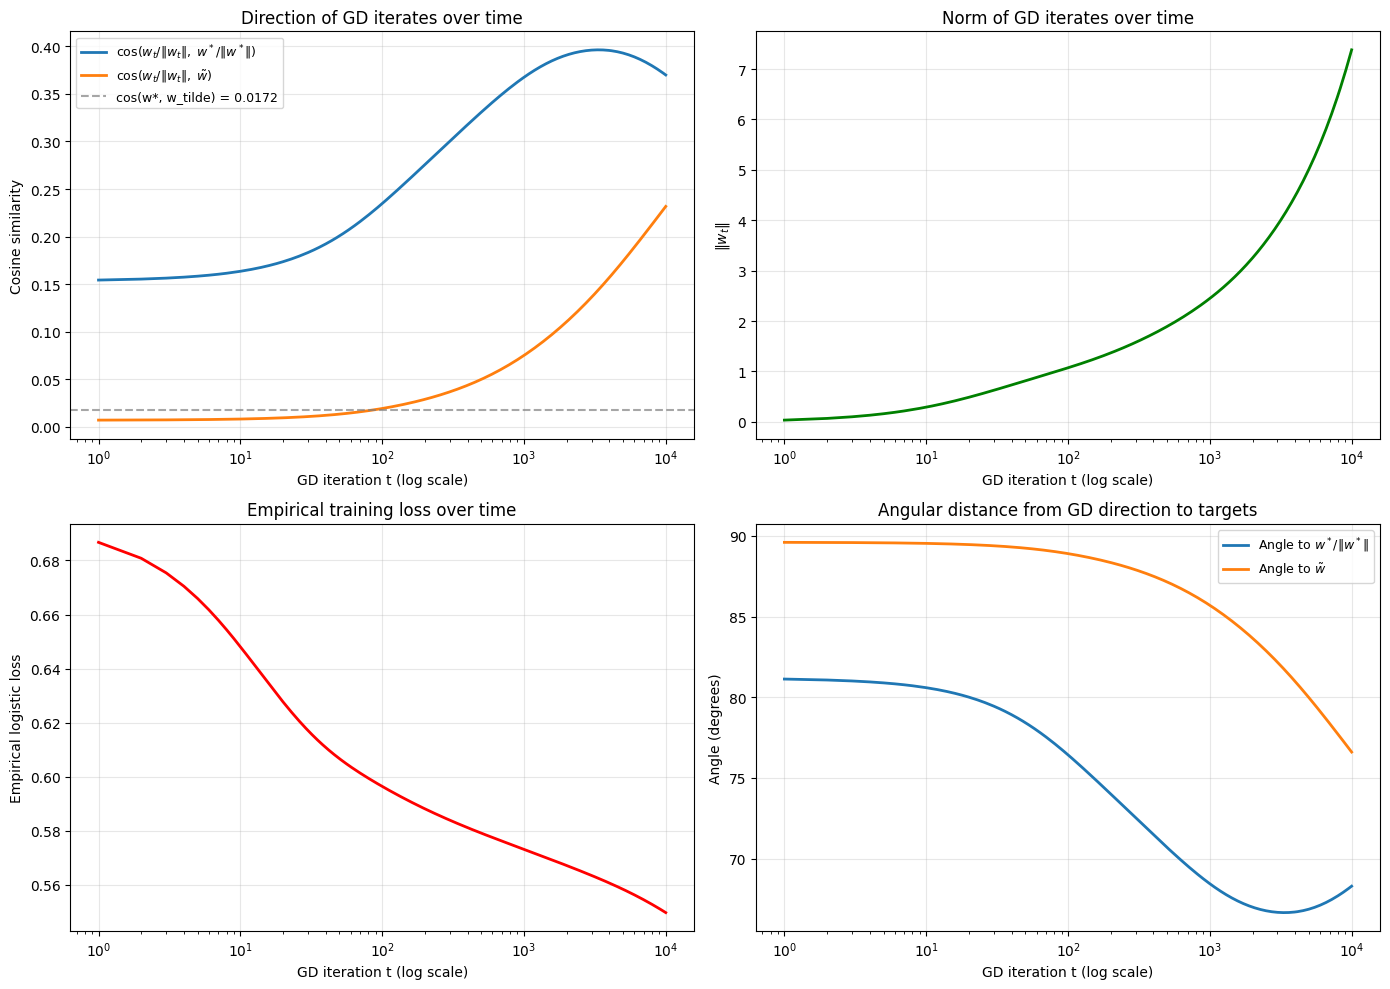

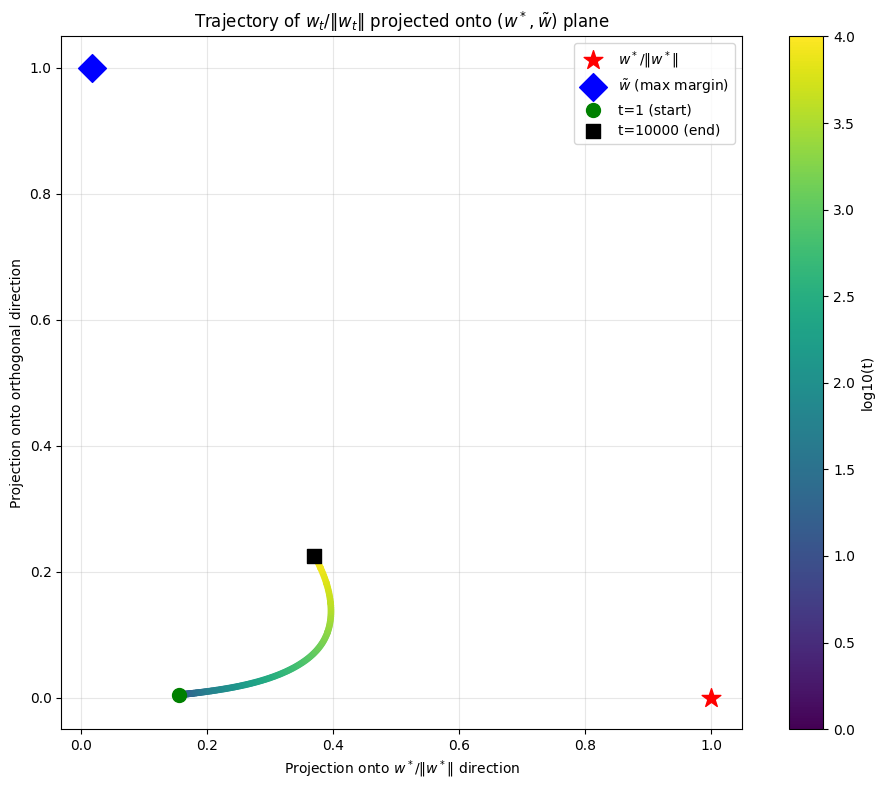

         t |   cos(w_t, w*) |  cos(w_t, w_tilde) |    ||w_t|| |  emp. loss
--------------------------------------------------------------------------
         1 |       0.154285 |           0.007063 |     0.0352 |   0.686715
        10 |       0.163498 |           0.008182 |     0.2923 |   0.648117
      2000 |       0.390837 |           0.110464 |     3.2518 |   0.567178
     10000 |       0.369874 |           0.231717 |     7.3803 |   0.549759


In [5]:
model.plot_dashboard()
model.plot_trajectory()
model.print_summary()

## Continue to longer horizon

Just change T below and run these two cells to extend the trajectory.

In [6]:
model.run_gd(T=50000)

Continuing GD from t=10000 to t=50000...
  t=   12000: loss=0.547041, ||w||=8.2513
  t=   14000: loss=0.544570, ||w||=9.0935
  t=   16000: loss=0.542293, ||w||=9.9108
  t=   18000: loss=0.540175, ||w||=10.7058
  t=   20000: loss=0.538189, ||w||=11.4807
  t=   22000: loss=0.536315, ||w||=12.2372
  t=   24000: loss=0.534538, ||w||=12.9769
  t=   26000: loss=0.532844, ||w||=13.7013
  t=   28000: loss=0.531224, ||w||=14.4115
  t=   30000: loss=0.529670, ||w||=15.1086
  t=   32000: loss=0.528176, ||w||=15.7935
  t=   34000: loss=0.526735, ||w||=16.4671
  t=   36000: loss=0.525343, ||w||=17.1302
  t=   38000: loss=0.523997, ||w||=17.7832
  t=   40000: loss=0.522692, ||w||=18.4270
  t=   42000: loss=0.521425, ||w||=19.0618
  t=   44000: loss=0.520194, ||w||=19.6883
  t=   46000: loss=0.518997, ||w||=20.3069
  t=   48000: loss=0.517830, ||w||=20.9179
  t=   50000: loss=0.516693, ||w||=21.5216
Done. Total checkpoints: 378


In [8]:
model.run_gd(T=100000)

Continuing GD from t=50000 to t=100000...
  t=   52000: loss=0.515584, ||w||=22.1185
  t=   54000: loss=0.514500, ||w||=22.7087
  t=   56000: loss=0.513441, ||w||=23.2925
  t=   58000: loss=0.512406, ||w||=23.8703
  t=   60000: loss=0.511392, ||w||=24.4422
  t=   62000: loss=0.510400, ||w||=25.0084
  t=   64000: loss=0.509427, ||w||=25.5692
  t=   66000: loss=0.508473, ||w||=26.1246
  t=   68000: loss=0.507538, ||w||=26.6750
  t=   70000: loss=0.506620, ||w||=27.2205
  t=   72000: loss=0.505719, ||w||=27.7611
  t=   74000: loss=0.504833, ||w||=28.2972
  t=   76000: loss=0.503963, ||w||=28.8287
  t=   78000: loss=0.503107, ||w||=29.3559
  t=   80000: loss=0.502266, ||w||=29.8788
  t=   82000: loss=0.501437, ||w||=30.3976
  t=   84000: loss=0.500622, ||w||=30.9125
  t=   86000: loss=0.499820, ||w||=31.4234
  t=   88000: loss=0.499029, ||w||=31.9305
  t=   90000: loss=0.498250, ||w||=32.4340
  t=   92000: loss=0.497482, ||w||=32.9338
  t=   94000: loss=0.496725, ||w||=33.4302
  t=   96000

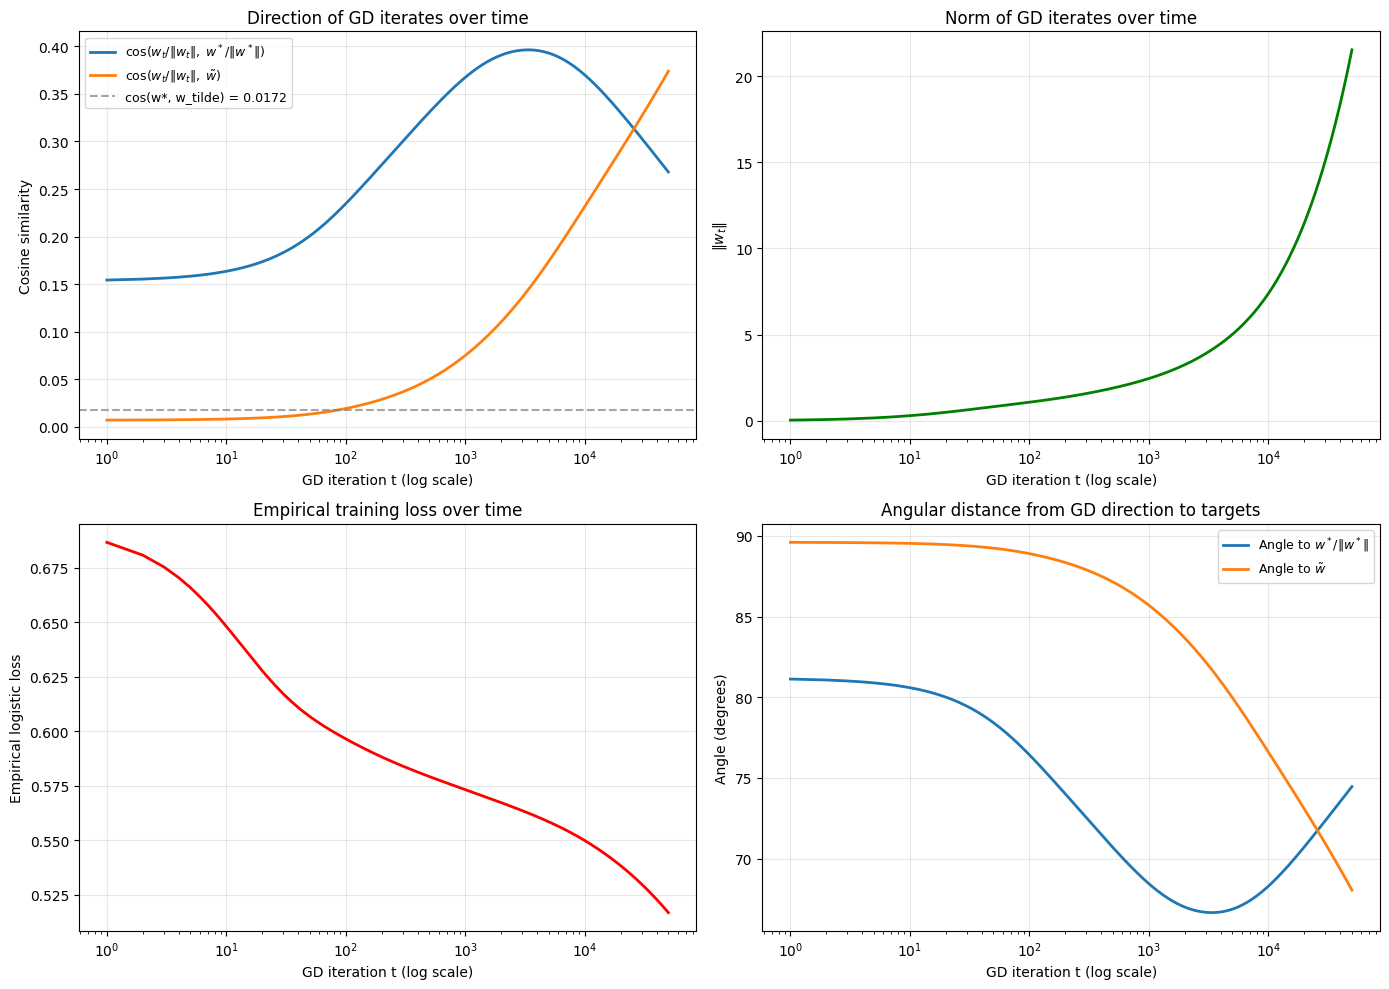

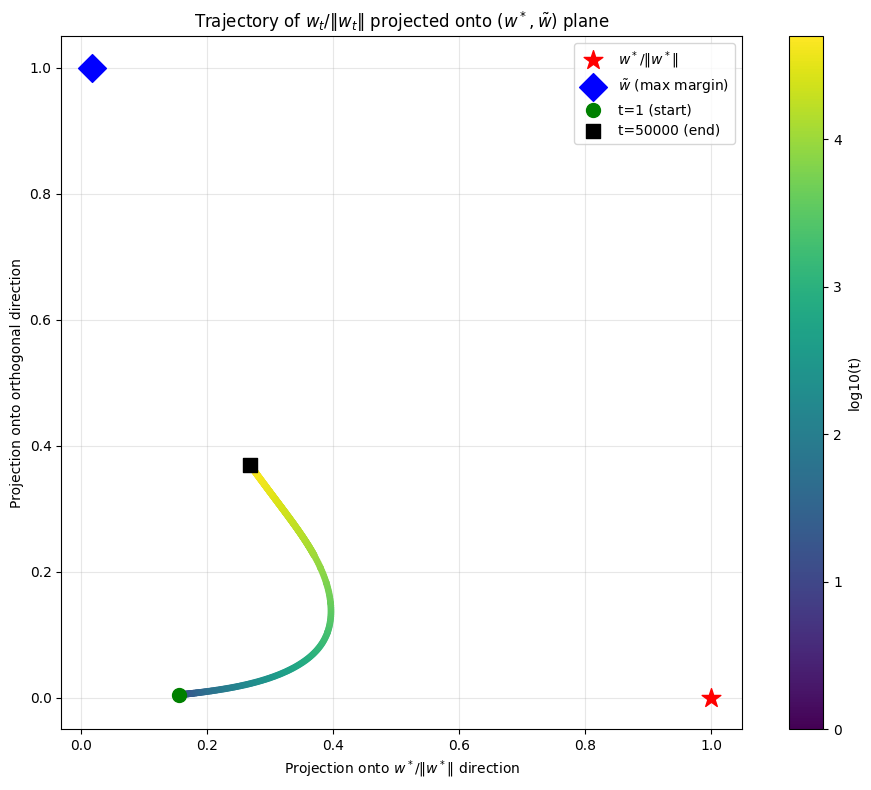

         t |   cos(w_t, w*) |  cos(w_t, w_tilde) |    ||w_t|| |  emp. loss
--------------------------------------------------------------------------
         1 |       0.154285 |           0.007063 |     0.0352 |   0.686715
        10 |       0.163498 |           0.008182 |     0.2923 |   0.648117
      2000 |       0.390837 |           0.110464 |     3.2518 |   0.567178
     10000 |       0.369874 |           0.231717 |     7.3803 |   0.549759
     50000 |       0.267895 |           0.373803 |    21.5216 |   0.516693


In [7]:
model.plot_dashboard()
model.plot_trajectory()
model.print_summary()

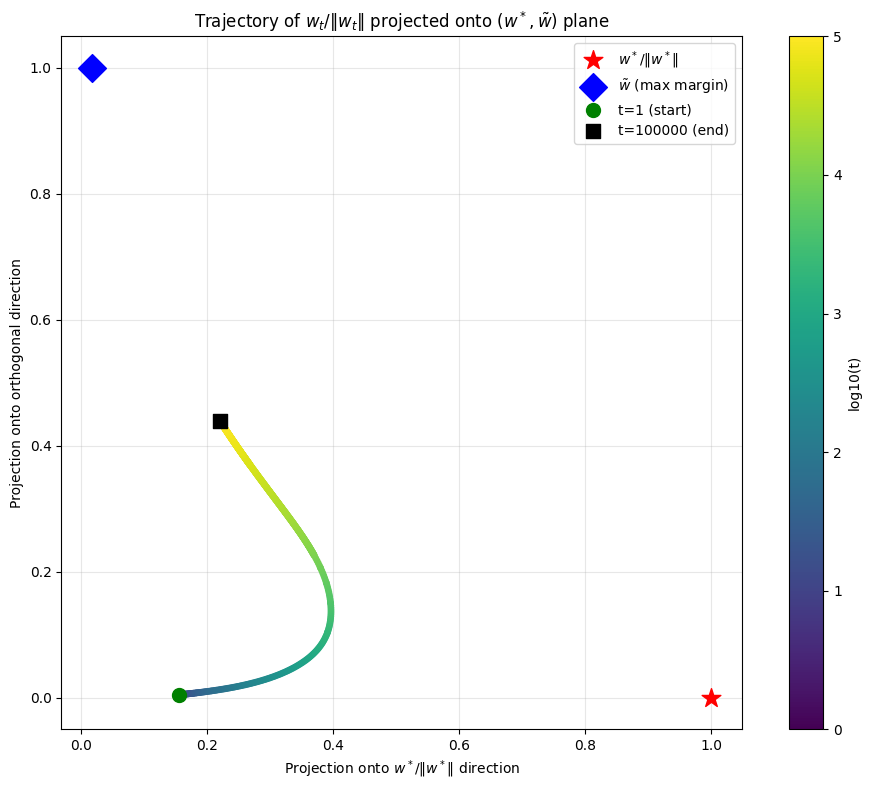

In [9]:
model.plot_trajectory()